In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

from thesis.utils.metrics import *

Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
IS_SAMPLE = False

In [4]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234

In [63]:
NUMBER_INDICATOR = "number_inidicator"
CURRENCY_INDICATOR = "currency_inidicator"
CHEMICAL_INDICATOR = "chemical_inidicator"
MIN_WORD_COUNT = 3
MIN_SIZE = 0
NUM_CORES = 16

In [6]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [76]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
TEST_MATRIX = "test_matrix.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"

In [28]:
#training_file = "/home/local/shalaby/docs_output_sample_100.json"

root_location = "/mnt/data2/shalaby/"
exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(root_location, "parameter_search_doc2vec_models_new_abstract", "full")
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

training_file = root_location + "docs_output.json"

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

abstracts_map_file = exports_location + "abstracts_tokenized_map.pkl"

preprocessed_location = root_location + "preprocessed_data/"

training_preprocessed_files_prefix = preprocessed_location + "training_docs_merged_data_preprocessed-"
training_preprocessed_docids_files_prefix = preprocessed_location + "training_docs_merged_docids_preprocessed-"
validation_preprocessed_files_prefix = preprocessed_location + "validation_docs_merged_data_preprocessed-"
validation_preprocessed_docids_files_prefix = preprocessed_location + "validation_docs_merged_docids_preprocessed-"

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

In [33]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 28.4 s, sys: 4.44 s, total: 32.9 s
Wall time: 32.9 s


In [29]:
%%time
abstracts_map = pickle.load(open(abstracts_map_file))

CPU times: user 4min 43s, sys: 48.2 s, total: 5min 31s
Wall time: 5min 32s


In [34]:
len(training_docs_list)

1286325

In [35]:
len(validation_docs_list)

321473

Only use the docs that have an abstract

In [36]:
training_docs_list = list(set(training_docs_list) - (set(training_docs_list) - set(abstracts_map.keys())))
validation_docs_list = list(set(validation_docs_list) - (set(validation_docs_list) - set(abstracts_map.keys())))
test_docs_list = list(set(test_docs_list) - (set(test_docs_list) - set(abstracts_map.keys())))

In [37]:
len(training_docs_list)

1279894

In [38]:
len(validation_docs_list)

319877

In [39]:
def stemtokenizer(text):
    """ MAIN FUNCTION to get clean stems out of a text. A list of clean stems are returned """
    tokenizer = RegexpTokenizer(r'\s+', gaps=True)
    tokens = tokenizer.tokenize(text)
    stems = []  # result
    for token in tokens:
        stem = token.lower()
        stem = stem.strip(string.punctuation)
        if stem:
            if is_number(stem):
                stem = NUMBER_INDICATOR
            elif is_currency(stem):
                stem = CURRENCY_INDICATOR
            elif is_chemical(stem):
                stem = CHEMICAL_INDICATOR
            else:
                stem = stem.strip(string.punctuation)
            if stem and len(stem) >= MIN_SIZE:
                # extract uni-grams
                stems.append(stem)
    del tokens
    return stems

def is_number(str):
    """ Returns true if given string is a number (float or int)"""
    try:
        float(str.replace(",", ""))
        return True
    except ValueError:
        return False

def is_currency(str):
    return str[0] == "$"

def is_chemical(str):
    return str.count("-") > 3

In [40]:
def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

In [86]:
def get_docs_with_inference(doc2vec_model, doc_classification_map, classifications,
                                           docs_list, file_to_write, abstracts_map):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation or test documents
    """

    def infer_one_doc(doc_tuple):
        # doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
        doc_id, doc_tokens = doc_tuple
        rep = doc2vec_model.infer_vector(doc_tokens)
        return (doc_id, rep)


    one_hot_encoder = OneHotEncoder(classifications)
    classifications_set = set(classifications)
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, file_to_write)):
        info("===== Loading inference vectors")
        inference_labels = []
        inference_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, file_to_write)))
        info("Loaded inference vectors matrix")
        for i, doc_id in enumerate(docs_list):
            curr_doc_labels = set(doc_classification_map[doc_id]) & classifications_set
            inference_labels.append(one_hot_encoder.get_label_vector(curr_doc_labels))
            if i % 100000 == 0:
                info("Finished {} in inference loading".format(i))
        inference_labels = np.array(inference_labels, dtype=np.int8)
    else:
        inference_documents_reps = {}
        inference_vectors = []
        inference_labels = []
        info("===== Getting vectors with inference")


        # Multi-threaded inference
        inference_docs_iterator = AbstractDocumentGenerator(abstracts_map, docs_list, False)
        generator_func = inference_docs_iterator.__iter__()
        pool = ThreadPool(NUM_CORES)
        # map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
#         mini_batch_size = 1000
#         while True:
#             threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(generator_func, mini_batch_size))
#             info("Finished: {}".format(str(inference_docs_iterator.curr_index)))
#             if threaded_reps_partial:
#                 # threaded_reps.extend(threaded_reps_partial)
#                 inference_documents_reps.update(threaded_reps_partial)
#             else:
#                 break

        threaded_reps_partial = pool.map(infer_one_doc, generator_func)
        info("Finished: {}".format(str(inference_docs_iterator.curr_index)))
        inference_documents_reps.update(threaded_reps_partial)

        # create matrix for the inferred vectors
        for doc_id in docs_list:
            inference_vectors.append(inference_documents_reps[doc_id])
            curr_doc_labels = set(doc_classification_map[doc_id]) & classifications_set
            inference_labels.append(one_hot_encoder.get_label_vector(curr_doc_labels))
        inference_vectors_matrix = np.array(inference_vectors)
        inference_labels = np.array(inference_labels, dtype=np.int8)
        pickle.dump(inference_vectors_matrix,
                    open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, file_to_write), 'w'))

    return inference_vectors_matrix, inference_labels

In [83]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector

def get_training_data(doc2vec_model, classifications):
    one_hot_encoder = OneHotEncoder(classifications)
    classifications_set = set(classifications)
    training_data = []
    training_labels_mat = np.zeros((len(training_docs_list), len(classifications)), dtype=np.int8)
    for i,doc_id in enumerate(training_docs_list):
        normal_array = doc2vec_model.docvecs[doc_id]
        training_data.append(normal_array)
        eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
        training_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
        if i % 100000 == 0:
            info("Finished {} in training".format(i))
    info("doing matrix creation")
    training_data_mat = np.array(training_data)
    del training_data
    return training_data_mat, training_labels_mat

In [82]:
class AbstractDocumentGenerator(object):
    def __init__(self, abstracts_map, document_list, return_labeled_sentence=True):
        self.abstracts_map = abstracts_map
        self.docs_list = document_list
        self.docs_set = set(self.docs_list)
        self.return_labeled_sentence = return_labeled_sentence
        self.curr_index = 0
    def __iter__(self):
        for i, doc_id in enumerate(self.abstracts_map):
            if doc_id in self.docs_set and self.abstracts_map.get(doc_id) is not None:
                text = self.abstracts_map[doc_id]
                if self.return_labeled_sentence:
                    yield LabeledSentence(words=text, tags=[doc_id])
                else:
                    yield doc_id, text
            self.curr_index += 1

### Doc2vec and SVM Parameters

In [103]:
DOC2VEC_SIZE = 500
DOC2VEC_WINDOW = 4
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 20
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 100000 # report vocab progress every x documents

In [104]:
SVM_ITERATIONS = 10
SVM_CONVERGENCE = 0.001
SVM_REG = 0.001
SVM_CLASS_WEIGHTS = None
GLOBAL_VARS.SVM_MODEL_NAME = 'svm_iter_{}_reg_{}_classweights_{}'.format(SVM_ITERATIONS, SVM_REG, str(SVM_CLASS_WEIGHTS))

In [105]:
def get_svm_model_path(method, classification, reg=SVM_REG, iterations=SVM_ITERATIONS):
    location = os.path.join(save_parent_location, "models", method, 
                            "iter_" + str(iterations) + "_reg_" + str(reg),
                            classification + "_model.svm")
    ensure_hdfs_location_exists(location)
    return location

## Create the Doc2vec model

In [106]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")
placeholder_model_name

'doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_{}'

In [107]:
doc2vec_model = Doc2Vec(size=DOC2VEC_SIZE , window=DOC2VEC_WINDOW, min_count=MIN_WORD_COUNT, 
                max_vocab_size= DOC2VEC_MAX_VOCAB_SIZE,
                sample=DOC2VEC_SAMPLE, seed=DOC2VEC_SEED, workers=NUM_CORES,
                # doc2vec algorithm dm=1 => PV-DM, dm=2 => PV-DBOW, PV-DM dictates CBOW for words
                dm=DOC2VEC_TYPE,
                # hs=0 => negative sampling, hs=1 => hierarchical softmax
                hs=DOC2VEC_HIERARCHICAL_SAMPLE, negative=DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                dm_concat=DOC2VEC_CONCAT,
                # 0 for sum, 1 for mean
                dm_mean=0 if DOC2VEC_MEAN != 2 else 1,
                # would train words with skip-gram on top of cbow, we don't need that for now
                dbow_words=DOC2VEC_TRAIN_WORDS,
                iter=DOC2VEC_EPOCHS)

GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

In [108]:
%%time
training_docs_iterator = AbstractDocumentGenerator(abstracts_map, training_docs_list)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX)):
    doc2vec_model.build_vocab(sentences=training_docs_iterator, progress_per=REPORT_VOCAB_PROGRESS)
    doc2vec_model.save(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
else:
    doc2vec_model_vocab_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
    doc2vec_model.reset_from(doc2vec_model_vocab_model)

2017-02-26 19:51:28,579 : INFO : collecting all words and their counts
2017-02-26 19:51:28,583 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-02-26 19:51:31,605 : INFO : PROGRESS: at example #100000, processed 10713666 words (3547687/s), 101619 word types, 100000 tags
2017-02-26 19:51:33,965 : INFO : PROGRESS: at example #200000, processed 21384107 words (4524544/s), 153654 word types, 200000 tags
2017-02-26 19:51:36,340 : INFO : PROGRESS: at example #300000, processed 32064844 words (4498821/s), 196489 word types, 300000 tags
2017-02-26 19:51:38,780 : INFO : PROGRESS: at example #400000, processed 42767189 words (4390312/s), 233764 word types, 400000 tags
2017-02-26 19:51:41,167 : INFO : PROGRESS: at example #500000, processed 53456551 words (4480994/s), 267398 word types, 500000 tags
2017-02-26 19:51:43,564 : INFO : PROGRESS: at example #600000, processed 64123059 words (4453212/s), 298880 word types, 600000 tags
2017-02-26 19:51:46,032 : INFO : 

CPU times: user 1min 20s, sys: 10.9 s, total: 1min 31s
Wall time: 1min 33s


In [97]:
# vocab_counts = {k:doc2vec_model.vocab[k].count for k in doc2vec_model.vocab.keys()}
# dd = sorted(vocab_counts, key=vocab_counts.get)

## Actual Training, validation and Metrics Loop

In [109]:
doc2vec_model.alpha = 0.025
doc2vec_model.min_alpha = 0.025
DOC2VEC_ALPHA_DECREASE = 0.001
epoch_validation_metrics = []
epoch_training_metrics = []
epoch_word2vec_metrics = []
classifications = sections
classifications_type = 'sections'

In [110]:
VALIDATION_METRICS_FILENAME= '{}_validation_metrics.pkl'.format(classifications_type)
TRAINING_METRICS_FILENAME = '{}_training_metrics.pkl'.format(classifications_type)
METRICS_FIG_PNG_FILENAME = '{}_validation_metrics.png'.format(classifications_type)
METRICS_FIG_PDF_FILENAME = '{}_validation_metrics.pdf'.format(classifications_type)
WORD2VEC_METRICS_FILENAME = 'word2vec_metrics.pkl'

# for epoch in range(DOC2VEC_MAX_EPOCHS):
#     GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
#     ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                              GLOBAL_VARS.SVM_MODEL_NAME))
#     pickle.dump(metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, GLOBAL_VARS.SVM_MODEL_NAME, METRICS), 'w'))
# fig_save_location = placeholder_model_name.format('run')
# plt.savefig(os.path.join(fig_save_location))

<IPython.core.display.Javascript object>


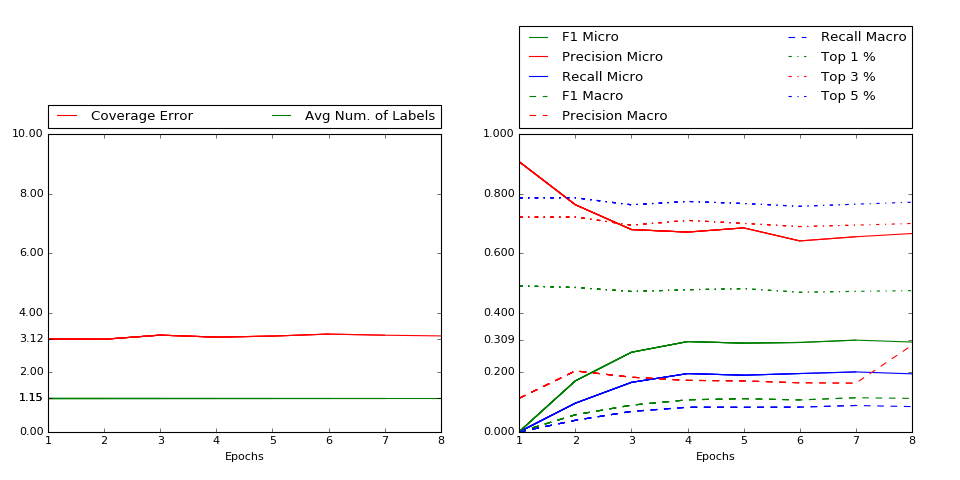

2017-02-27 00:36:21,341 : INFO : ****************** Epoch 1 --- Working on doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1 *******************
2017-02-27 00:36:21,343 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abstract/full/doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model
2017-02-27 00:36:27,168 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abstract/full/doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.docvecs.* with mmap=None
2017-02-27 00:36:27,172 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abstract/full/doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.docvecs.doctag_syn0.npy with mmap=None
2017-02-27 00:36:37,536 : INFO : loading syn1neg from /mnt/

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.125, Avg Labels: 1.150, 
		 Top 1: 0.491, Top 3: 0.722, Top 5: 0.787, 
		 F1 Micro: 0.001, F1 Macro: 0.000, Total Pos: 250


2017-02-27 00:40:24,179 : INFO : ****************** Epoch 2 --- Working on doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2 *******************
2017-02-27 00:40:24,209 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abstract/full/doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model
2017-02-27 00:46:54,442 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abstract/full/doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model.docvecs.* with mmap=None
2017-02-27 00:46:54,447 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abstract/full/doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model.docvecs.doctag_syn0.npy with mmap=None
2017-02-27 00:47:13,193 : INFO : loading syn1neg from /mnt/

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.117, Avg Labels: 1.150, 
		 Top 1: 0.486, Top 3: 0.722, Top 5: 0.787, 
		 F1 Micro: 0.172, F1 Macro: 0.058, Total Pos: 46,632


2017-02-27 00:54:52,101 : INFO : ****************** Epoch 3 --- Working on doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3 *******************
2017-02-27 00:54:52,139 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abstract/full/doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model
2017-02-27 00:55:04,783 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abstract/full/doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model.docvecs.* with mmap=None
2017-02-27 00:55:04,788 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abstract/full/doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model.docvecs.doctag_syn0.npy with mmap=None
2017-02-27 00:55:12,493 : INFO : loading syn1neg from /mnt/

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.255, Avg Labels: 1.150, 
		 Top 1: 0.472, Top 3: 0.695, Top 5: 0.763, 
		 F1 Micro: 0.268, F1 Macro: 0.090, Total Pos: 90,127


2017-02-27 00:57:44,879 : INFO : ****************** Epoch 4 --- Working on doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4 *******************
2017-02-27 00:57:51,197 : INFO : training model with 22 workers on 181046 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-02-27 00:57:51,203 : INFO : expecting 1279894 sentences, matching count from corpus used for vocabulary survey
2017-02-27 00:57:58,684 : INFO : PROGRESS: at 0.01% examples, 1253 words/s, in_qsize 43, out_qsize 0
2017-02-27 00:58:18,702 : INFO : PROGRESS: at 1.76% examples, 67891 words/s, in_qsize 44, out_qsize 0
2017-02-27 00:58:38,749 : INFO : PROGRESS: at 4.13% examples, 89296 words/s, in_qsize 44, out_qsize 0
2017-02-27 00:58:58,759 : INFO : PROGRESS: at 6.83% examples, 102480 words/s, in_qsize 43, out_qsize 0
2017-02-27 00:59:18,793 : INFO : PROGRESS: at 9.48% examples, 108981 words/s, in_qsize 43, out_qsize 0
2017-02-27 00:59:38,908 : INFO : PROGRESS

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]]
** Validation Metrics: Cov Err: 3.188, Avg Labels: 1.150, 
		 Top 1: 0.478, Top 3: 0.711, Top 5: 0.775, 
		 F1 Micro: 0.304, F1 Macro: 0.108, Total Pos: 107,372


2017-02-27 01:34:28,104 : INFO : ****************** Epoch 5 --- Working on doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_5 *******************
2017-02-27 01:34:35,828 : INFO : training model with 22 workers on 181046 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-02-27 01:34:35,834 : INFO : expecting 1279894 sentences, matching count from corpus used for vocabulary survey
2017-02-27 01:34:44,139 : INFO : PROGRESS: at 0.01% examples, 1109 words/s, in_qsize 43, out_qsize 0
2017-02-27 01:35:04,290 : INFO : PROGRESS: at 0.98% examples, 36249 words/s, in_qsize 44, out_qsize 0
2017-02-27 01:35:24,368 : INFO : PROGRESS: at 3.34% examples, 70764 words/s, in_qsize 43, out_qsize 0
2017-02-27 01:35:44,378 : INFO : PROGRESS: at 6.57% examples, 97139 words/s, in_qsize 44, out_qsize 0
2017-02-27 01:36:04,394 : INFO : PROGRESS: at 10.00% examples, 113704 words/s, in_qsize 44, out_qsize 0
2017-02-27 01:36:24,422 : INFO : PROGRESS

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.222, Avg Labels: 1.150, 
		 Top 1: 0.482, Top 3: 0.701, Top 5: 0.768, 
		 F1 Micro: 0.299, F1 Macro: 0.112, Total Pos: 102,263


2017-02-27 02:09:57,109 : INFO : ****************** Epoch 6 --- Working on doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6 *******************
2017-02-27 02:10:00,898 : INFO : training model with 22 workers on 181046 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-02-27 02:10:00,902 : INFO : expecting 1279894 sentences, matching count from corpus used for vocabulary survey
2017-02-27 02:10:08,629 : INFO : PROGRESS: at 0.01% examples, 2400 words/s, in_qsize 43, out_qsize 0
2017-02-27 02:10:28,645 : INFO : PROGRESS: at 2.52% examples, 108152 words/s, in_qsize 44, out_qsize 0
2017-02-27 02:10:48,665 : INFO : PROGRESS: at 5.78% examples, 132632 words/s, in_qsize 43, out_qsize 0
2017-02-27 02:11:08,726 : INFO : PROGRESS: at 9.48% examples, 148136 words/s, in_qsize 43, out_qsize 0
2017-02-27 02:11:28,730 : INFO : PROGRESS: at 13.44% examples, 159293 words/s, in_qsize 43, out_qsize 0
2017-02-27 02:11:48,748 : INFO : PROGR

[[0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.290, Avg Labels: 1.150, 
		 Top 1: 0.470, Top 3: 0.690, Top 5: 0.758, 
		 F1 Micro: 0.301, F1 Macro: 0.108, Total Pos: 112,426


2017-02-27 02:32:36,327 : INFO : ****************** Epoch 7 --- Working on doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7 *******************
2017-02-27 02:32:36,716 : INFO : training model with 22 workers on 181046 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-02-27 02:32:36,720 : INFO : expecting 1279894 sentences, matching count from corpus used for vocabulary survey
2017-02-27 02:32:38,568 : INFO : PROGRESS: at 0.17% examples, 142882 words/s, in_qsize 44, out_qsize 0
2017-02-27 02:32:58,602 : INFO : PROGRESS: at 7.01% examples, 326048 words/s, in_qsize 44, out_qsize 0
2017-02-27 02:33:18,617 : INFO : PROGRESS: at 13.78% examples, 329480 words/s, in_qsize 43, out_qsize 0
2017-02-27 02:33:38,670 : INFO : PROGRESS: at 20.62% examples, 331622 words/s, in_qsize 44, out_qsize 0
2017-02-27 02:33:58,695 : INFO : PROGRESS: at 27.41% examples, 332203 words/s, in_qsize 44, out_qsize 0
2017-02-27 02:34:18,749 : INFO : P

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]]
** Validation Metrics: Cov Err: 3.252, Avg Labels: 1.150, 
		 Top 1: 0.473, Top 3: 0.695, Top 5: 0.766, 
		 F1 Micro: 0.309, F1 Macro: 0.115, Total Pos: 113,022


2017-02-27 03:08:02,362 : INFO : ****************** Epoch 8 --- Working on doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8 *******************
2017-02-27 03:08:07,929 : INFO : training model with 22 workers on 181046 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-02-27 03:08:07,939 : INFO : expecting 1279894 sentences, matching count from corpus used for vocabulary survey
2017-02-27 03:08:12,092 : INFO : PROGRESS: at 0.01% examples, 2038 words/s, in_qsize 44, out_qsize 0
2017-02-27 03:08:32,148 : INFO : PROGRESS: at 2.22% examples, 92793 words/s, in_qsize 43, out_qsize 0
2017-02-27 03:08:52,153 : INFO : PROGRESS: at 5.26% examples, 119108 words/s, in_qsize 44, out_qsize 0
2017-02-27 03:09:12,206 : INFO : PROGRESS: at 8.83% examples, 136859 words/s, in_qsize 44, out_qsize 1
2017-02-27 03:09:32,256 : INFO : PROGRESS: at 12.47% examples, 146830 words/s, in_qsize 44, out_qsize 0
2017-02-27 03:09:52,291 : INFO : PROGRE

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
** Validation Metrics: Cov Err: 3.229, Avg Labels: 1.150, 
		 Top 1: 0.475, Top 3: 0.701, Top 5: 0.772, 
		 F1 Micro: 0.302, F1 Macro: 0.113, Total Pos: 107,665


2017-02-27 03:36:31,631 : INFO : ****************** Epoch 9 --- Working on doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_9 *******************
2017-02-27 03:36:35,233 : INFO : training model with 22 workers on 181046 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=10
2017-02-27 03:36:35,253 : INFO : expecting 1279894 sentences, matching count from corpus used for vocabulary survey
2017-02-27 03:36:38,595 : INFO : PROGRESS: at 0.01% examples, 3116 words/s, in_qsize 43, out_qsize 0
2017-02-27 03:36:58,654 : INFO : PROGRESS: at 2.41% examples, 106203 words/s, in_qsize 44, out_qsize 0
2017-02-27 03:37:18,669 : INFO : PROGRESS: at 5.71% examples, 132995 words/s, in_qsize 43, out_qsize 0
2017-02-27 03:37:38,715 : INFO : PROGRESS: at 9.66% examples, 152606 words/s, in_qsize 44, out_qsize 0
2017-02-27 03:37:58,745 : INFO : PROGRESS: at 13.86% examples, 165522 words/s, in_qsize 43, out_qsize 0
2017-02-27 03:38:18,794 : INFO : PROGR

IOError: 639947000 requested and 66490348 written

In [115]:
%%time
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph(len(classifications) +2)
# when resuming, resume from an epoch with a previously created doc2vec model to get the learning rate right
start_from = 1
for epoch in range(start_from, DOC2VEC_MAX_EPOCHS+1):
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))
    
    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
    else:
        # train the doc2vec model
        training_docs_iterator = AbstractDocumentGenerator(abstracts_map, training_docs_list)
        doc2vec_model.train(sentences=training_docs_iterator, report_delay=REPORT_DELAY)
        doc2vec_model.alpha -= DOC2VEC_ALPHA_DECREASE  # decrease the learning rate
        doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay
        ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
        doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
        
        # get the word2vec analogy accuracy score
#         word2vec_result = doc2vec_model.accuracy(word2vec_questions_file, restrict_vocab=None)
#         epoch_word2vec_metrics.append(word2vec_result)
#         pickle.dump(word2vec_result, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME,
#                                                        WORD2VEC_METRICS_FILENAME), 'w'))


    ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                             GLOBAL_VARS.SVM_MODEL_NAME))
    
    if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, CLASSIFIER)):

        info('Getting training Data')
        X, y = get_training_data(doc2vec_model, classifications)
        
        info('Training Classifier')
        clf = OneVsRestClassifier(linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                                             #alpha is the 1/C parameter
                                                             alpha=SVM_REG, fit_intercept=True, n_iter=SVM_ITERATIONS,
                                                             #n_jobs=-1 means use all cpus
                                                             shuffle=True, verbose=0, n_jobs=1,
                                                             #eta0 is the learning rate when we use constant configuration
                                                             random_state=SVM_SEED, learning_rate='optimal', eta0=0.0, 
                                                             class_weight=SVM_CLASS_WEIGHTS, warm_start=False), n_jobs=1)


        # Training of a classifier
        clf.fit(X,y)
        pickle.dump(clf, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                              GLOBAL_VARS.SVM_MODEL_NAME, CLASSIFIER), 'w'))
        
    #     # Training Metrics
    #     info('Evaluating on Training Data')
    #     yp = clf.predict(X)
    #     yp_score = clf.decision_function(X)
    #     print yp
    #     training_metrics = get_metrics(y, yp_score, yp)
    #     print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
    #         training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
    #         training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
    #         training_metrics['f1_micro'], training_metrics['f1_macro'], training_metrics['total_positive'])

    #     epoch_training_metrics.append(training_metrics)
          # Saving the metrics
    #     pickle.dump(training_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
    #                                                           GLOBAL_VARS.SVM_MODEL_NAME, TRAINING_METRICS_FILENAME), 'w'))
        del X, y

    else:
        info('Loading Classifier')
        clf = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, CLASSIFIER), 'r'))

    # Validation Metrics
    info('Getting Validation Embeddings')
    Xv, yv = get_docs_with_inference(doc2vec_model, doc_classification_map, classifications, 
                                                    validation_docs_list, VALIDATION_MATRIX, abstracts_map)
    info('Evaluating on Validation Data')
    yvp = clf.predict(Xv)
    yvp_score = clf.decision_function(Xv)
    print yvp
    validation_metrics = get_metrics(yv, yvp_score, yvp)
    print "** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
        validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
        validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive'])
    
    graph.add_metrics_to_graph(validation_metrics, epoch)
    
    epoch_validation_metrics.append(validation_metrics)
    
    
    # Saving the metrics
#     pickle.dump(training_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                                           GLOBAL_VARS.SVM_MODEL_NAME, TRAINING_METRICS_FILENAME), 'w'))
    pickle.dump(validation_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, VALIDATION_METRICS_FILENAME), 'w'))


In [114]:
doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))

2017-02-26 23:26:11,267 : INFO : saving Doc2Vec object under /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abstract/full/doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4/model, separately None
2017-02-26 23:26:11,273 : INFO : storing numpy array 'doctag_syn0' to /mnt/data2/shalaby/parameter_search_doc2vec_models_new_abstract/full/doc2vec_size_500_w_4_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4/model.docvecs.doctag_syn0.npy


In [36]:
GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(6)
info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))

# if we have the model, just load it, otherwise train the previous model
if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
    doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))

2017-01-07 08:32:48,888 : INFO : ****************** Epoch 6 --- Working on doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6 *******************
2017-01-07 08:32:48,891 : INFO : loading Doc2Vec object from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model
2017-01-07 08:33:14,046 : INFO : loading docvecs recursively from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.docvecs.* with mmap=None
2017-01-07 08:33:14,048 : INFO : loading doctag_syn0 from /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-07 08:33:21,936 : INFO : loading syn1neg from /big/s/shalaby/parameter_search_doc2vec_mode

In [35]:
%%time
ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

# get the word2vec analogy accuracy score
%time word2vec_result = doc2vec_model.accuracy(word2vec_questions_file, restrict_vocab=None)
epoch_word2vec_metrics.append(word2vec_result)
pickle.dump(word2vec_result, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME,
                                               WORD2VEC_METRICS_FILENAME), 'w'))


2017-01-07 08:05:32,383 : INFO : saving Doc2Vec object under /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model, separately None
2017-01-07 08:05:32,384 : INFO : storing numpy array 'doctag_syn0' to /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.docvecs.doctag_syn0.npy
2017-01-07 08:06:07,546 : INFO : storing numpy array 'syn1neg' to /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.syn1neg.npy
2017-01-07 08:06:22,413 : INFO : not storing attribute syn0norm
2017-01-07 08:06:22,414 : INFO : storing numpy array 'syn0' to /big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.syn

CPU times: user 3h 47min 44s, sys: 4h 31min 2s, total: 8h 18min 46s
Wall time: 21min 14s
CPU times: user 3h 48min 38s, sys: 4h 31min 12s, total: 8h 19min 51s
Wall time: 23min 18s
